Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


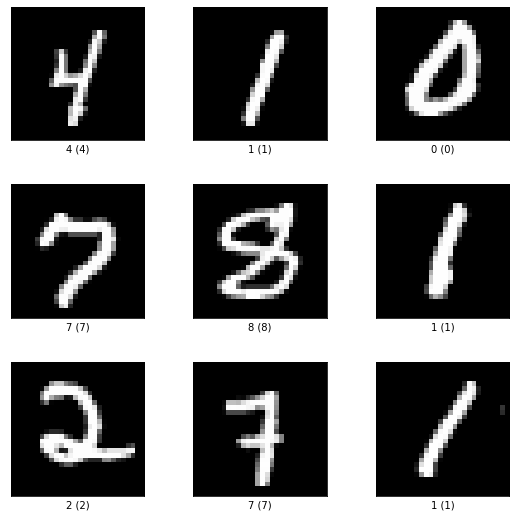

In [2]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [3]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


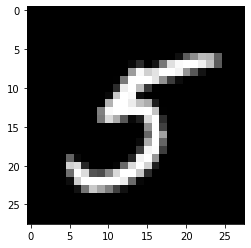

In [4]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


In [8]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


In [9]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.977942943572998, D:0.17974036931991577
[1/10 EPOCHS, 200 ITER] G:2.5235986709594727, D:0.11105018854141235
[1/10 EPOCHS, 300 ITER] G:2.8747127056121826, D:0.1350916028022766
[1/10 EPOCHS, 400 ITER] G:2.8258347511291504, D:0.11394459009170532
[2/10 EPOCHS, 100 ITER] G:4.49906587600708, D:0.06371302157640457
[2/10 EPOCHS, 200 ITER] G:4.30918025970459, D:0.15686766803264618
[2/10 EPOCHS, 300 ITER] G:3.3990588188171387, D:0.3777790069580078
[2/10 EPOCHS, 400 ITER] G:4.209432125091553, D:0.09252986311912537
[3/10 EPOCHS, 100 ITER] G:3.7387003898620605, D:0.3336328864097595
[3/10 EPOCHS, 200 ITER] G:4.269169807434082, D:0.11499617993831635
[3/10 EPOCHS, 300 ITER] G:3.9597721099853516, D:0.09134089201688766
[3/10 EPOCHS, 400 ITER] G:3.9110517501831055, D:0.10114151239395142
[4/10 EPOCHS, 100 ITER] G:4.359554290771484, D:0.1743019074201584
[4/10 EPOCHS, 200 ITER] G:4.959043979644775, D:0.04161272943019867
[4/10 EPOCHS, 300 ITER] G:3.0737619400024414, D:0.13280817866

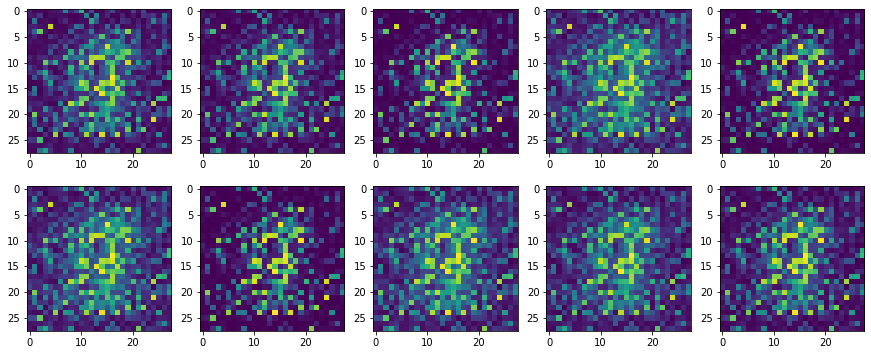

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

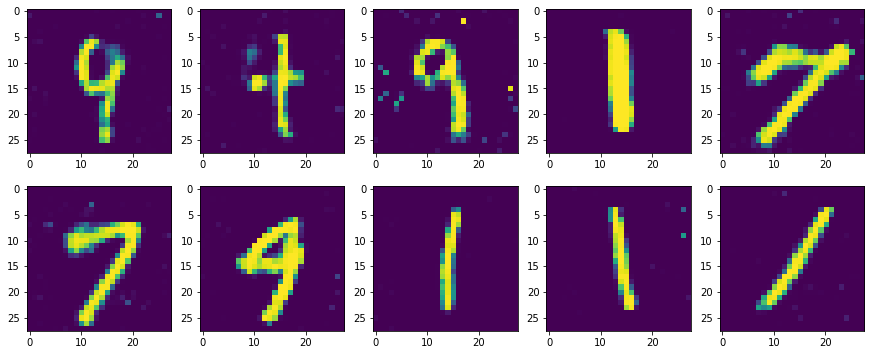

In [14]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [15]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.0216474533081055, D:0.0073182424530386925
[1/1 EPOCHS, 199 ITER] G:4.682331085205078, D:0.020294226706027985
[1/1 EPOCHS, 299 ITER] G:5.280126571655273, D:0.07309677451848984
[1/1 EPOCHS, 399 ITER] G:6.733378887176514, D:0.006369855720549822


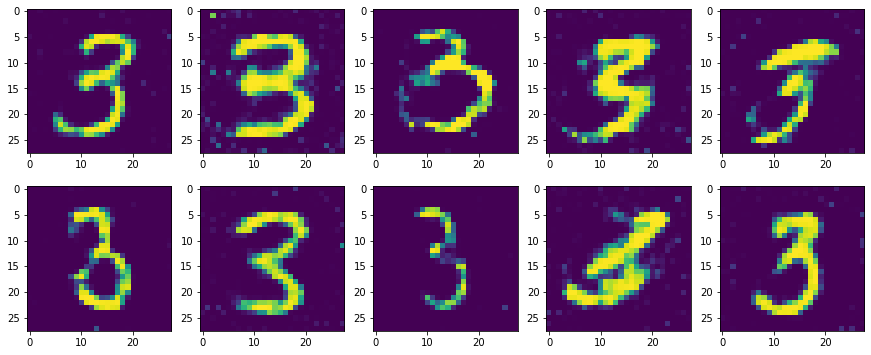

In [16]:
number = 3

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])